In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

**Importing useful packages**

In [4]:
import matplotlib.pyplot as plt
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import tensorflow as tf

# **Loading and Preprocessing the data**

In [6]:
train_data = pd.read_csv('/fashion-mnist_test.csv')
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


dropping the labels from the dataset

In [7]:
X_train = train_data.drop('label',axis=1)
X_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,9,8,0,...,103,87,56,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,14,53,99,17,...,0,0,0,0,63,53,31,0,0,0
3,0,0,0,0,0,0,0,0,0,161,...,137,126,140,0,133,224,222,56,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X_train=X_train.values
print(X_train.shape)

(10000, 784)


In [9]:
X_train=X_train.reshape(-1,28,28,1)
print(X_train.shape)

(10000, 28, 28, 1)


# **Data Visualization**

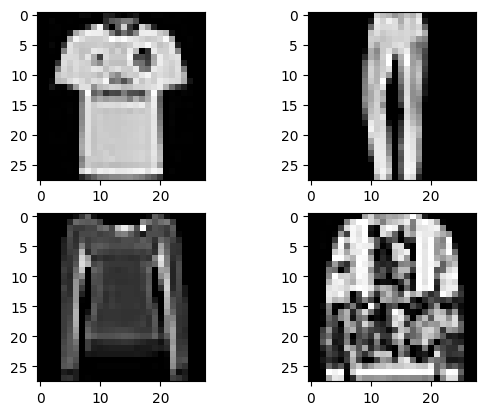

In [10]:
fig,axe=plt.subplots(2,2)
idx = 0
for i in range(2):
    for j in range(2):
        axe[i,j].imshow(X_train[idx].reshape(28,28),cmap='gray')
        idx+=1

In [11]:
X_train =  X_train.astype('float32')

The pixel data ranges from 0 to 255 hence dividing each pixel by 255,i.e,normalizing the data such that the range is within 0 to 1.

In [12]:
X_train = X_train/255
X_train = X_train*2 - 1.

**NOTE**  after normalizing it is multiplied with 2 and substracted from 1 such that it ranges from (-1,1) because in DCGANs the last layer generative model activation is tanh which range is (-1,1) unlike sigmoid ranging (0,1) .

In [13]:
print(X_train.max(),X_train.min())

1.0 -1.0


# **Simple GAN Model**

**Generative part**

In [14]:
generator = Sequential()
generator.add(Dense(512,input_shape=[100]))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(128))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(784))
generator.add(Reshape([28,28,1]))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [15]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │          51,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 784)                 │         101,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 320,656 (1.22 MB)

 Trainable params: 318,864 (1.22 MB)

 Non-trainable params: 1,792 (7.00 KB)

**Discriminatory part**

In [16]:
discriminator = Sequential()
discriminator.add(Dense(1,input_shape=[28,28,1]))
discriminator.add(Flatten())
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(64))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1,activation='sigmoid'))

In [17]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 28, 28, 1)           │               2 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 242,179 (946.01 KB)

 Trainable params: 242,179 (946.01 KB)

 Non-trainable params: 0 (0.00 B)

1. Compiling the discriminator layer
2. Compiling the GAN

NOTE : the generator layer is not compiled seperately because it gets trained as part of the combined model but training the discriminator is necessary because it is trained before the combined model.

In [18]:
GAN =Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [19]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [20]:
GAN.layers

[<Sequential name=sequential, built=True>,
 <Sequential name=sequential_1, built=True>]

In [21]:
GAN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 28, 28, 1)           │         320,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │         242,179 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 562,835 (2.15 MB)

 Trainable params: 318,864 (1.22 MB)

 Non-trainable params: 243,971 (953.01 KB)

In [22]:
epochs = 30
batch_size = 100
noise_shape=100

Currently on Epoch 1
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


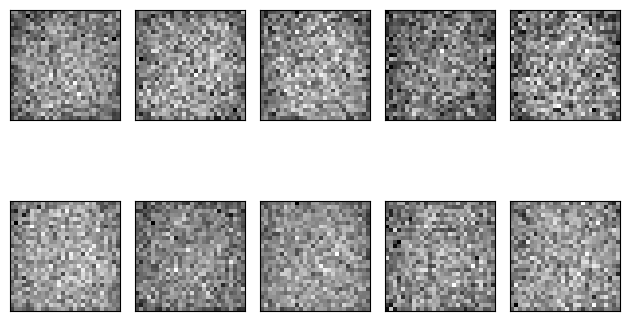

Currently on Epoch 2
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 3
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 4
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 5
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 6
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 7
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 8
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 9
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 10
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 11
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


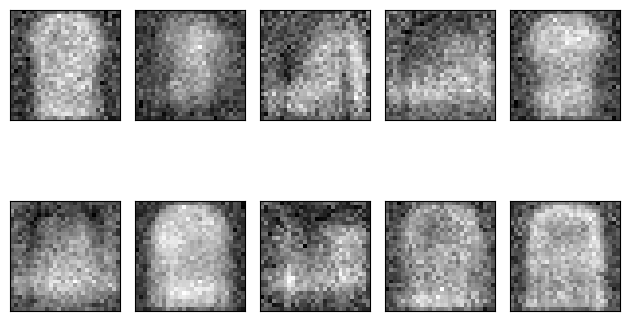

Currently on Epoch 12
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 13
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 14
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 15
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 16
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 17
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 18
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 19
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 20
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 21
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37

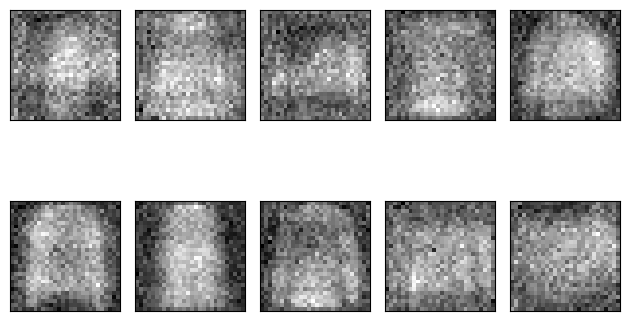

Currently on Epoch 22
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 23
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 24
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 25
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 26
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 27
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 28
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 29
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 30
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Training is complete


In [23]:
with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")


    for i in range(X_train.shape[0]//batch_size):

        if (i+1)%50 == 0:
            print(f"\tCurrently on batch number {i+1} of {X_train.shape[0]//batch_size}")

        noise=np.random.normal(size=[batch_size,noise_shape])

        gen_image = generator.predict_on_batch(noise)

        train_dataset = X_train[i*batch_size:(i+1)*batch_size]

        #training discriminator on real images
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss_real=discriminator.train_on_batch(train_dataset,train_label)

        #training discriminator on fake images
        train_label=np.zeros(shape=(batch_size,1))
        d_loss_fake=discriminator.train_on_batch(gen_image,train_label)


        #training generator
        noise=np.random.normal(size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False

        d_g_loss_batch =GAN.train_on_batch(noise, train_label)




    #plotting generated images at the start and then after every 10 epoch
    if epoch % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()



print('Training is complete')

In [24]:
noise=np.random.normal(size=[10,noise_shape])

gen_image = generator.predict(noise)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


noise generated using np.random.normal is given to as input to the generator. In the next step the generator produces batches of meaningful alike image from the random distribution.

Text(0.5, 1.0, 'How the noise looks')

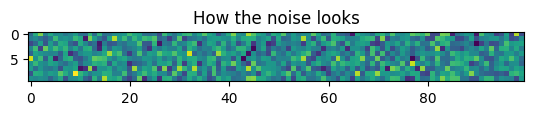

In [25]:
plt.imshow(noise)
plt.title('How the noise looks')

**Generator producing images from noise**

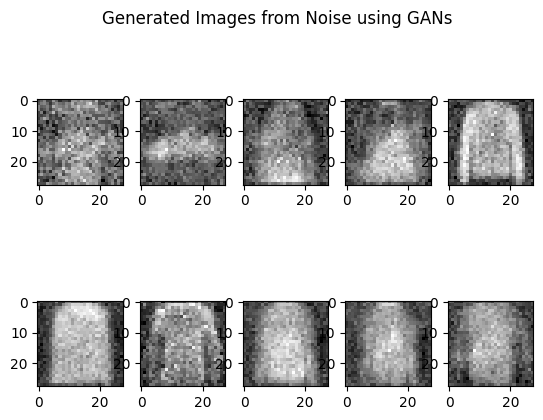

In [26]:
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using GANs')
idx=0
for i in range(2):
    for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=1

**Inference from generated images**

As discussed before after iterating through few tens of epochs the generator learns to trick the discriminator with only one specific category of output image and hence stops learning beyond that point. The ouput after complete training is thus only single type of images almost similar in features ,i.e, shirts in this particular case and there is no variation in generated image features.

The above issue can be resolved using DCGANs as given below.

# **GAN using Deep Convolutions**

In this model we construct the generator using transpose convolution layers instead of simple dense layers which helps better in feature capturing and prevents the issue as described earlier. Similarly while building the discriminator layer,instead of simple dense units it uses convolution layers to increase efficiency of it's classification.


![GANsdeep.png](attachment:GANsdeep.png)


The paper that proposed this architecture https://arxiv.org/abs/1511.06434
To know more about Conv2D https://keras.io/layers/convolutional/

In [27]:
generator = Sequential()
generator.add(Dense(7 * 7 * 128, input_shape=[100]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh"))

In [28]:
generator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 6272)                │         633,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 840,705 (3.21 MB)

 Trainable params: 840,321 (3.21 MB)

 Non-trainable params: 384 (1.50 KB)

In [29]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
discriminator.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
GAN =Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [32]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [33]:
GAN.layers

[<Sequential name=sequential_3, built=True>,
 <Sequential name=sequential_4, built=True>]

In [34]:
GAN.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 28, 28, 1)           │         840,705 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 1)                   │         212,865 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,053,570 (4.02 MB)

 Trainable params: 840,321 (3.21 MB)

 Non-trainable params: 213,249 (833.00 KB)

In [35]:
epochs = 40 #vary epoch size as per required to train the model
batch_size = 100

In [36]:
noise_shape=100

Currently on Epoch 1
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


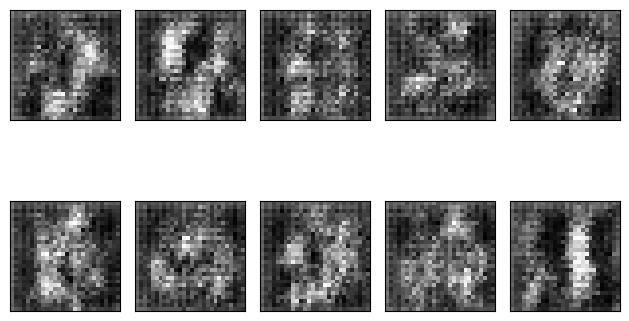

Currently on Epoch 2
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 3
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 4
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 5
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 6
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 7
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 8
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 9
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 10
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 11
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


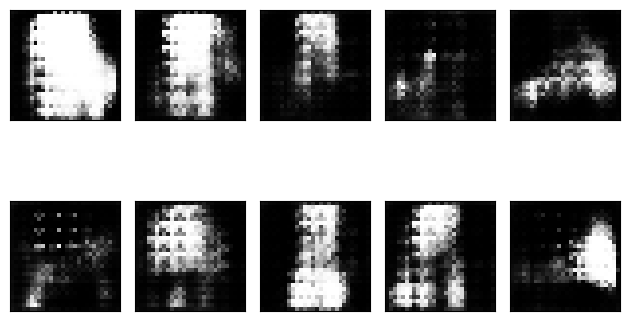

Currently on Epoch 12
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 13
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 14
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 15
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 16
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 17
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 18
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 19
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 20
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 21
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46

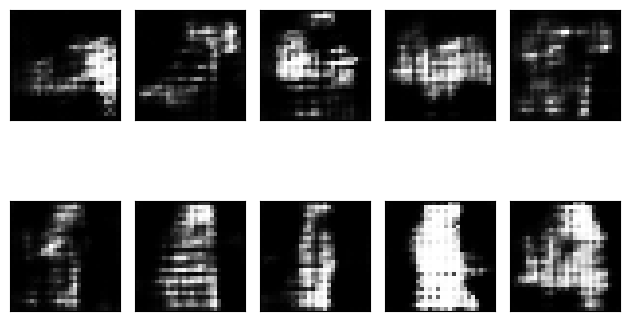

Currently on Epoch 22
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 23
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 24
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 25
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 26
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 27
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 28
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 29
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 30
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 31
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48

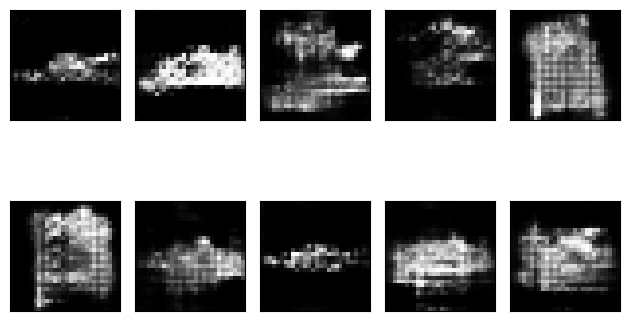

Currently on Epoch 32
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 33
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 34
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 35
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 36
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 37
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 38
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 39
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Currently on Epoch 40
	Currently on batch number 50 of 100
	Currently on batch number 100 of 100
Training is complete


In [37]:

with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")


    for i in range(X_train.shape[0]//batch_size):

        if (i+1)%50 == 0:
            print(f"\tCurrently on batch number {i+1} of {X_train.shape[0]//batch_size}")

        noise=np.random.normal(size=[batch_size,noise_shape])

        gen_image = generator.predict_on_batch(noise)

        train_dataset = X_train[i*batch_size:(i+1)*batch_size]

        #training discriminator on real images
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss_real=discriminator.train_on_batch(train_dataset,train_label)

        #training discriminator on fake images
        train_label=np.zeros(shape=(batch_size,1))
        d_loss_fake=discriminator.train_on_batch(gen_image,train_label)


        #training generator
        noise=np.random.normal(size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False #while training the generator as combined model,discriminator training should be turned off

        d_g_loss_batch =GAN.train_on_batch(noise, train_label)




    #plotting generated images at the start and then after every 10 epoch
    if epoch % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()



print('Training is complete')

In [38]:
noise=np.random.normal(loc=0, scale=1, size=(100,noise_shape))

gen_image = generator.predict(noise)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


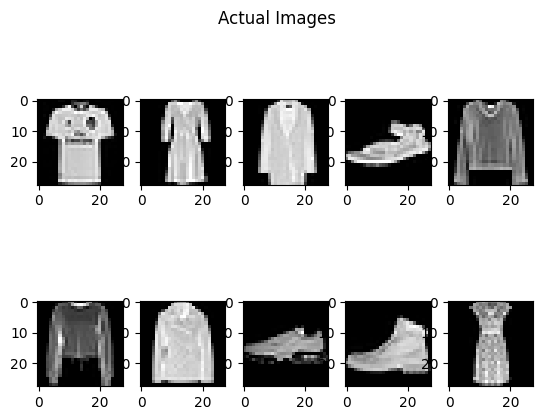

In [39]:
fig,axe=plt.subplots(2,5)
fig.suptitle("Actual Images")
idx = 0
for i in range(2):
    for j in range(5):
        axe[i,j].imshow(X_train[idx].reshape(28,28),cmap='gray')
        idx+=10

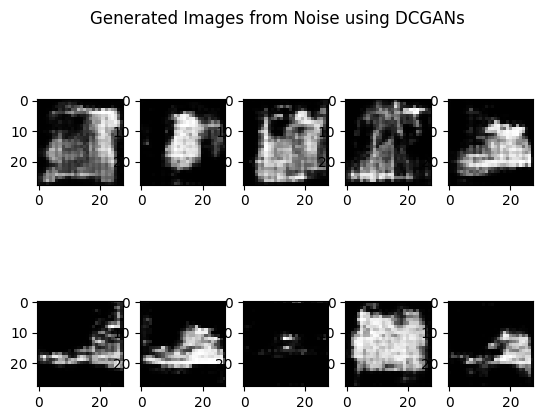

In [40]:
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using DCGANs')
idx=0
for i in range(2):
     for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=3